# Analyse des textes

In [1]:
# Prendre la version condaforge de yellowbrick**
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pyLDAvis.gensim_models
import pyLDAvis

from collections import Counter
import re

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

import gensim
import gensim.corpora as corpora

from pprint import pprint

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to /home/reda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/reda/anaconda3/envs/P6/lib/python3.9/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
df_review = pd.read_csv('data/yelp_dataset/csv/df_review.csv')
df_business = pd.read_csv('data/yelp_dataset/csv/df_business.csv')

## Analyse exploratoire des textes

Pour notre analyse exploratoires des textes, nous allons commencer nettoyer les commentaires, nous allons prendre les 100 premiers négatifs.

# Fonctions

In [3]:
def nettoyage_texte(df):
    # regex r'[a-zA-Z]{1,}' : ne garde que les mots (pas de valeurs numériques)
    tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]{1,}')
    for i in range(len(df)):
        cleaning_texte = tokenizer.tokenize(df['text'][i])
        # Passe toutes les majuscules en minuscules
        cleaning_texte = [
            each_string.lower() for each_string in cleaning_texte
        ]
        df['text'][i] = cleaning_texte

    return df


def supprimer_stopwords(df):
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'u'])

    for i in range(len(df)):
        for stopword in stop_words:
            for word in df['text'][i]:
                if stopword == word:
                    df['text'][i].remove(stopword)

    return df


def stopwords_perso(df):
    # Cette fonctionne suppriment les 20 mots les plus frequents parmis tous
    # les commentaires

    # Place tous les mots du corpus dans la liste 'liste_des_textes'
    liste_des_textes = []
    for i in range(len(df)):
        for y in df['text'][i]:
            liste_des_textes.append(y)
    # Comptabilise le nombre de mots de la liste
    dict_count_texte = Counter(liste_des_textes)
    # Range le dictionnaire dans l'odre décroissant
    dict_decroissant = dict(
        reversed(sorted(dict_count_texte.items(), key=lambda item: item[1])))

    dict_20_premier_mots = {
        k: dict_decroissant[k]
        for k in list(dict_decroissant)[:20]
    }
    liste_stopword = dict_20_premier_mots.keys()

    # supprime les stopwords_perso de la dataframe
    for i in range(len(df)):
        for stopword in liste_stopword:
            for word in df['text'][i]:
                if stopword == word:
                    df['text'][i].remove(stopword)

    return df


def lemmatisation(texts):
    allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']

    texts_out = []
    doc = nlp(" ".join(texts))
    for word in texts:
        texts_out.append(
            [word.lemma_ for word in doc if word.pos_ in allowed_postags])

    return texts_out[0]


def lemmatisation_remove(df):
    for i in range(len(df)):
        texte = lemmatisation(df['text'][i])
        df['text'][i] = texte

    return df


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Nettoyage

In [4]:
# Selection des colonnes utiles uniquement
df_review = df_review[["business_id", "text"]]
df_bad_review = df_review.copy()
df_bad_review_cleaning = df_review.copy()

In [5]:
df_review.head(10)

,business_id,text
0,04UD14gamNjLY0IDYVhHJg,I am a long term frequent customer of this est...
1,jNL5KUPz2-tHUJM__ysSaw,If you want to pay for everything a la carte t...
2,Wy8Hswf2cLQGRZN6armkag,"If I could give it a zero, I would. I order a ..."
3,aY_n9RSaD2Yw09jSFFePew,We visited once and were very disappointed in ...
4,cg4JFJcCxRTTMmcg9O9KtA,Skip this train wreck if you are looking for d...
5,GyC36Pn0Q1-qHnqXys6yFg,Service and management terrible... After messi...
6,EBn3U4mpnIRLIy2lKuilRQ,Been to this location twice and will never go ...
7,29YqJwOGEuAWqlHZxMc1OA,So disappointing on so many levels. Have been ...
8,bjhCtlYHrkgA5Ku8l-rB3g,Very disappointed. We went to eat at 2:15 on ...
9,o7cD_sDA-Evj3Oh0zeH9nQ,Hands down the worst chicken and rice plate I'...


In [6]:
df_bad_review_cleaning.shape

(1615, 2)

In [7]:
%%time
df_bad_review_cleaning = nettoyage_texte(df_bad_review_cleaning)
df_bad_review_cleaning = supprimer_stopwords(df_bad_review_cleaning)
df_bad_review_cleaning = stopwords_perso(df_bad_review_cleaning)
df_bad_review_cleaning = lemmatisation_remove(df_bad_review_cleaning)

CPU times: user 12 s, sys: 41.4 ms, total: 12.1 s
Wall time: 12 s


In [8]:
df_bad_review_cleaning.head(6)

,business_id,text
0,04UD14gamNjLY0IDYVhHJg,"[long, term, frequent, customer, establishment..."
1,jNL5KUPz2-tHUJM__ysSaw,"[want, pay, terrible, impressive, bring, baske..."
2,Wy8Hswf2cLQGRZN6armkag,"[give, plain, hamburger, realize, put, bacon, ..."
3,aY_n9RSaD2Yw09jSFFePew,"[visit, disappointed, veggie, husband, sub, sa..."
4,cg4JFJcCxRTTMmcg9O9KtA,"[skip, train, wreck, look, dinner, server, clu..."
5,GyC36Pn0Q1-qHnqXys6yFg,"[management, terrible, mess, order, waiter, ma..."


Nos textes sont maintenant nettoyés.

# Analyse LDA

Nous allons travailler à la transformation des données textuelles dans un format qui servira d'entrée pour l'entraînement du modèle LDA. Nous commençons par tokeniser le texte et supprimer les mots d'arrêt. Ensuite, nous convertissons l'objet tokénisé en un corpus et un dictionnaire.

Des fonctions similaires aux précédentes vont être ajoutées.

Nous utiliserons ici les bi-gram et tri-gram. En effet, TF-IDF n'est pas vraiment approprié pour LDA:
source : 
- https://datascience.stackexchange.com/questions/21950/why-we-should-not-feed-lda-with-tfidf
- https://stackoverflow.com/questions/44781047/necessary-to-apply-tf-idf-to-new-documents-in-gensim-lda-model/44789327#44789327

In [9]:
# Convertis la liste de mot en chaine de caractère
df_bad_review_cleaning["text_processed"] = None
for i in range(len(df_bad_review_cleaning["text"])):
    texte = df_bad_review_cleaning["text"][i]
    df_bad_review_cleaning["text_processed"][i] = " ".join(texte)

df_bad_review_cleaning.head(5)

,business_id,text,text_processed
0,04UD14gamNjLY0IDYVhHJg,"[long, term, frequent, customer, establishment...",long term frequent customer establishment go t...
1,jNL5KUPz2-tHUJM__ysSaw,"[want, pay, terrible, impressive, bring, baske...",want pay terrible impressive bring basket chip...
2,Wy8Hswf2cLQGRZN6armkag,"[give, plain, hamburger, realize, put, bacon, ...",give plain hamburger realize put bacon allergi...
3,aY_n9RSaD2Yw09jSFFePew,"[visit, disappointed, veggie, husband, sub, sa...",visit disappointed veggie husband sub sandwich...
4,cg4JFJcCxRTTMmcg9O9KtA,"[skip, train, wreck, look, dinner, server, clu...",skip train wreck look dinner server clueless s...


In [10]:
data_words = df_bad_review_cleaning.text.values.tolist()
print(data_words[:1][0][:30])

['long', 'term', 'frequent', 'customer', 'establishment', 'go', 'take', 'app', 'tell', 'busy', 'really', 'maybe', 'full', 'good', 'dick', 'reach', 'ass', 'fuck', 'frequent', 'customer', 'great', 'tipper', 'glad', 'open', 'go', 'dmitris']


In [11]:
# Construire les modèles bigramme
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)

# Une façon plus rapide d'obtenir une phrase classée comme bigramme
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Voir l'exemple du trigramme
print(bigram_mod[data_words[0]])

['long', 'term', 'frequent', 'customer', 'establishment', 'go', 'take', 'app', 'tell', 'busy', 'really', 'maybe', 'full', 'good', 'dick', 'reach', 'ass', 'fuck', 'frequent', 'customer', 'great', 'tipper', 'glad', 'open', 'go', 'dmitris']


In [12]:
# Application de la fonction make_bigrams
data_words_bigrams = make_bigrams(data_words)

print(data_words_bigrams[:1])

[['long', 'term', 'frequent', 'customer', 'establishment', 'go', 'take', 'app', 'tell', 'busy', 'really', 'maybe', 'full', 'good', 'dick', 'reach', 'ass', 'fuck', 'frequent', 'customer', 'great', 'tipper', 'glad', 'open', 'go', 'dmitris']]


In [13]:
# Créer un dictionnaire
id2word = corpora.Dictionary(data_words_bigrams)
# Créer un corpus
texts = data_words_bigrams
# TDF
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)]


In [14]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('app', 1),
  ('ass', 1),
  ('busy', 1),
  ('customer', 2),
  ('dick', 1),
  ('dmitris', 1),
  ('establishment', 1),
  ('frequent', 2),
  ('fuck', 1),
  ('full', 1),
  ('glad', 1),
  ('go', 2),
  ('good', 1),
  ('great', 1),
  ('long', 1),
  ('maybe', 1),
  ('open', 1),
  ('reach', 1),
  ('really', 1),
  ('take', 1),
  ('tell', 1),
  ('term', 1),
  ('tipper', 1)]]

## LDA model training

Pour garder les choses simples, nous conserverons tous les paramètres par défaut, à l'exception de la saisie du nombre de sujets. 

Nous allons construire un modèle de base avec 6 sujets où chaque sujet est une combinaison de mots-clés, et chaque mot-clé contribue à un certain poids pour le sujet.

In [15]:
# nombre de sujets
num_topics = 6
# Construire un modèle LDA
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True,
                                       iterations=1000,
                                       random_state=np.random.RandomState(100))
# Imprimer le mot-clé dans les x sujets
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.013*"come" + 0.012*"wait" + 0.012*"bad" + 0.011*"take" + 0.009*"give" + '
  '0.008*"go" + 0.008*"ever" + 0.008*"tell" + 0.008*"customer" + '
  '0.007*"drive"'),
 (1,
  '0.011*"take" + 0.010*"go" + 0.010*"tell" + 0.010*"ask" + 0.010*"come" + '
  '0.008*"wait" + 0.007*"bad" + 0.006*"table" + 0.006*"make" + 0.006*"first"'),
 (2,
  '0.012*"location" + 0.011*"bad" + 0.009*"look" + 0.008*"customer" + '
  '0.008*"ask" + 0.008*"make" + 0.008*"fry" + 0.007*"taste" + 0.007*"go" + '
  '0.007*"come"'),
 (3,
  '0.009*"eat" + 0.009*"go" + 0.009*"make" + 0.008*"bad" + 0.008*"salad" + '
  '0.008*"want" + 0.007*"ask" + 0.007*"try" + 0.007*"tell" + 0.007*"look"'),
 (4,
  '0.012*"make" + 0.008*"take" + 0.007*"come" + 0.007*"go" + 0.007*"give" + '
  '0.007*"restaurant" + 0.007*"ask" + 0.007*"well" + 0.007*"tell" + '
  '0.006*"chicken"'),
 (5,
  '0.009*"go" + 0.008*"give" + 0.007*"eat" + 0.007*"call" + 0.007*"business" + '
  '0.007*"take" + 0.006*"bad" + 0.006*"look" + 0.006*"say" + 0.006*"wait"'

In [16]:
from gensim.models import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(
    corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=data_words_bigrams,
                                     dictionary=id2word,
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.570510934235964

Coherence Score:  0.3260825533690327


La perplexité du modèle et la cohérence du sujet fournissent une mesure pratique pour juger de la qualité d'un modèle de sujet donné.

Voyons si nous pouvons améliorer notre modèle.

## Trouver le nombre optimal de topic

Notre approche pour trouver le nombre optimal de sujets consiste à construire de nombreux modèles LDA avec différentes valeurs du nombre de sujets (k) et à choisir celui qui donne la valeur de cohérence la plus élevée.

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                num_topics=num_topics,
                                                id2word=id2word,
                                                alpha='auto',
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
%%time
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus,
    texts=data_words_bigrams,
    start=2,
    limit=20,
    step=2)

CPU times: user 36.2 s, sys: 692 ms, total: 36.8 s
Wall time: 38.6 s


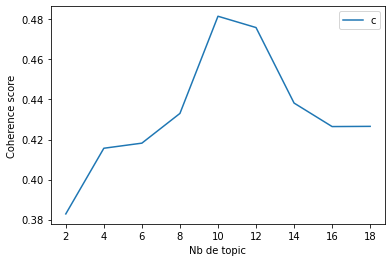

In [19]:
# Show graph
limit = 20
start = 2
step = 2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Nb de topic")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3829
Num Topics = 4  has Coherence Value of 0.4157
Num Topics = 6  has Coherence Value of 0.4182
Num Topics = 8  has Coherence Value of 0.433
Num Topics = 10  has Coherence Value of 0.4816
Num Topics = 12  has Coherence Value of 0.4759
Num Topics = 14  has Coherence Value of 0.4382
Num Topics = 16  has Coherence Value of 0.4265
Num Topics = 18  has Coherence Value of 0.4266


Nous aurons un meilleurs score avec ce modèle si nous prenons 8 topic (nous passerons alors d'un score de 0.32 environ à 0.50).

In [21]:
# Sélection du modèle avec le meilleurs score
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.027*"customer" + 0.026*"order" + 0.023*"horrible" + 0.017*"charge" + '
  '0.015*"line" + 0.015*"roll" + 0.014*"breakfast" + 0.014*"half" + '
  '0.014*"people" + 0.013*"counter"'),
 (1,
  '0.032*"ask" + 0.027*"tell" + 0.026*"take" + 0.025*"wait" + 0.023*"come" + '
  '0.021*"drink" + 0.017*"call" + 0.015*"table" + 0.015*"leave" + '
  '0.013*"hour"'),
 (2,
  '0.048*"owner" + 0.047*"hotel" + 0.033*"egg" + 0.018*"bougie" + '
  '0.018*"kardashian" + 0.018*"emilio" + 0.017*"fill" + 0.017*"milk" + '
  '0.016*"month" + 0.014*"sad"'),
 (3,
  '0.051*"subway" + 0.033*"save" + 0.031*"mushroom" + 0.029*"lettuce" + '
  '0.028*"nasty" + 0.018*"replace" + 0.017*"prepare" + 0.017*"crust" + '
  '0.016*"tomato" + 0.016*"veggie"'),
 (4,
  '0.020*"bad" + 0.020*"go" + 0.016*"give" + 0.016*"make" + 0.014*"eat" + '
  '0.014*"ever" + 0.012*"well" + 0.012*"look" + 0.012*"restaurant" + '
  '0.010*"try"'),
 (5,
  '0.031*"downtown" + 0.021*"shame" + 0.020*"straw" + 0.020*"truck" + '
  '0.019*"napkin" + 0.

## Analyzing LDA model results

Maintenant que nous disposons d'un modèle entraîné, visualisons les sujets pour en faciliter l'interprétation. 

Nous utiliserons la librairie **pyLDAvis** qui est conçu pour aider de manière interactive à :

- Mieux comprendre et interpréter les sujets individuels
- Mieux comprendre les relations entre les sujets.

In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

/home/reda/anaconda3/envs/P6/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/home/reda/anaconda3/envs/P6/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/reda/anaconda3/envs/P6/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/reda/anaconda3/envs/P6/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/reda/anaconda3/envs/P6/lib/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.323532  0.012252       1        1  49.250280
1     -0.321533  0.130891       2        1  27.631395
0     -0.068899 -0.365738       3        1   8.476609
6      0.052881  0.067146       4        1   5.710200
2      0.116201  0.033245       5        1   2.440806
7      0.117017  0.032104       6        1   2.235178
8      0.113961  0.026459       7        1   1.510621
3      0.109124  0.021936       8        1   1.393465
5      0.103811  0.021265       9        1   0.755933
9      0.100969  0.020439      10        1   0.595513, topic_info=              Term        Freq       Total Category  logprob  loglift
25             ask  561.000000  561.000000  Default  30.0000  30.0000
3         customer  371.000000  371.000000  Default  29.0000  29.0000
20            tell  467.000000  467.000000  Default  28.0000  28.0000
234        chicken  181.000000  181.000000  Default  27.0000  27.0000
148           wait  465.000000  465.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
1425     sandwhich    1.217488    1.967544  Topic10  -5.7128   4.6435
1424  professional    1.209434    1.956893  Topic10  -5.7194   4.6423
4932         reset    1.211011    1.959909  Topic10  -5.7181   4.6421
4881           dim    1.075478    1.823869  Topic10  -5.8368   4.5953
3476        cousin    0.880915    1.628587  Topic10  -6.0364   4.5090

[395 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
407       3  0.985918   absolutely
2784      6  0.948380       accuse
461       3  0.971956  acknowledge
334       5  0.947427     addition
1210      8  0.962106   additional
...     ...       ...          ...
538       1  0.849848         work
538       3  0.149689         work
1146      1  0.991920        wrong
1421      3  0.992056         yelp
565       3  0.982743          yet

[436 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 7, 3, 8, 9, 4, 6, 10])

Que voyons-nous ici ?

**Dans le panneau de gauche**, intitulé Intertopic Distance Map, les cercles représentent différents sujets et la distance qui les sépare. Les sujets similaires apparaissent plus proches et les sujets dissemblables plus éloignés. La taille relative du cercle d'un sujet dans le graphique correspond à la fréquence relative du sujet dans le corpus.

**Le panneau de droite**, comprend le diagramme à barres des 30 premiers termes. Lorsqu'aucun sujet n'est sélectionné dans le graphique de gauche, le diagramme à barres affiche les 30 termes les plus "saillants" du corpus.

In [23]:
# Récupère les topic avec leur liste de mots
top_words = {}
for topic, word in optimal_model.show_topics():
    top_words[topic] = re.sub('[^A-Za-z ]+', '', word)
print(top_words)

{0: 'customer  order  horrible  charge  line  roll  breakfast  half  people  counter', 1: 'ask  tell  take  wait  come  drink  call  table  leave  hour', 2: 'owner  hotel  egg  bougie  kardashian  emilio  fill  milk  month  sad', 3: 'subway  save  mushroom  lettuce  nasty  replace  prepare  crust  tomato  veggie', 4: 'bad  go  give  make  eat  ever  well  look  restaurant  try', 5: 'downtown  shame  straw  truck  napkin  mile  dog  simply  otherwise  fee', 6: 'chicken  sauce  delivery  salad  small  portion  tasteless  bland  rice  beef', 7: 'purchase  type  forever  fix  shoestring  one  slice  unacceptable  bartender  very', 8: 'garlic  pasta  truly  movie  smell  pork  potato  daughter  tongue  casually', 9: 'none  shrimp  boyfriend  consistently  selection  b  past  school  redeem  crowd'}


D'après notre LDA, nous pouvons attribuer 5 topiques, les topic de 5 à 10 peuvent être fusionnés en 1 seul topic vu leur ressemblance sur le graphique :
- Topic 1 : **Ambiance** (bad  go  give  make  eat  ever  well  look  restaurant  try)
- Topic 2 : **Attente** (ask  tell  take  wait  come  drink  call  table  leave  hour)
- Topic 3 : **Service** (customer  order  horrible  charge  line  roll  breakfast  half  people  counter)
- Topic 4 : **Livraison** (chicken  sauce  delivery  salad  small  portion  tasteless  bland  rice  beef)
- Topic 5 : **Nourriture** (Les 5 derniers sujets qui ressortent contiennent principalement des noms de nourriture)

Passons maintenant au NMF pour voir quels seront les topic qui en ressortirons.

# NMF

La méthode NMF est une méthode statistique qui nous aide à réduire la dimension des corpus d'entrée. En interne, elle utilise la méthode d'analyse factorielle pour donner comparativement moins de poids aux mots qui ont moins de cohérence.

In [24]:
df_NMF = df_bad_review_cleaning[["business_id", "text_processed"]].copy()
df_NMF.head(2)

,business_id,text_processed
0,04UD14gamNjLY0IDYVhHJg,long term frequent customer establishment go t...
1,jNL5KUPz2-tHUJM__ysSaw,want pay terrible impressive bring basket chip...


In [25]:
# Récupère seulement les noms
def extract_nouns(texts):
    output = []
    for doc in nlp.pipe(texts):
        nouns = " ".join(token.lemma_ for token in doc if token.pos_ == 'NOUN')
        output.append(nouns)
    return output


df_NMF['Review_Only_Nouns'] = extract_nouns(df_NMF['text_processed'])

In [26]:
df_NMF.head(2)

,business_id,text_processed,Review_Only_Nouns
0,04UD14gamNjLY0IDYVhHJg,long term frequent customer establishment go t...,term customer establishment app dick fuck cust...
1,jNL5KUPz2-tHUJM__ysSaw,want pay terrible impressive bring basket chip...,bring basket chip tomato sauce pico bring bott...


In [27]:
vec = TfidfVectorizer(max_features=7000,
                      stop_words="english",
                      max_df=0.95,
                      min_df=2)
features = vec.fit_transform(df_NMF.Review_Only_Nouns)

In [28]:
n_topics = 5
random_state = 42
nmf = NMF(n_components=n_topics, random_state=random_state)
nmf.fit(features)

/home/reda/anaconda3/envs/P6/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=5, random_state=42)

Afin de visualiser l'ensemble des mots qui composent chaque sujet, nous allons créer une fonction d'aide qui imprimera les 10 premiers mots de chaque sujet .

In [29]:
def display_top_words(feature_names, nmf, n_top_words):
    # topic x : top_word
    dict_nfm = {}
    # topic x : top_10_word
    dict_nfm_word = {}
    for i, topic_vec in enumerate(nmf.components_):
        # Créer les clefs de chaque dictionnaire avec le numero de topic
        # correspondant
        dict_nfm["topic " + str(i)] = None
        dict_nfm_word["topic " + str(i)] = None
        list_word = []
        for fid in topic_vec.argsort()[-1:-n_top_words - 1:-1]:
            # Place les mots de chaque topics dans une liste pour qu'elle
            # soit ensuite attribué au topic en clef concerné
            list_word.append(feature_names[fid])

            dict_nfm["topic " + str(i)] = feature_names[fid]
            dict_nfm_word["topic " + str(i)] = list_word
    return dict_nfm, dict_nfm_word

In [30]:
dict_topic, dict_word = display_top_words(vec.get_feature_names(), nmf, 10)
print(dict_topic)
print('\n')
print(dict_word)

{'topic 0': 'business', 'topic 1': 'attitude', 'topic 2': 'bread', 'topic 3': 'order', 'topic 4': 'waitress'}


{'topic 0': ['restaurant', 'owner', 'review', 'way', 'quality', 'area', 'experience', 'year', 'thing', 'business'], 'topic 1': ['location', 'customer', 'employee', 'manager', 'staff', 'drive', 'order', 'time', 'work', 'attitude'], 'topic 2': ['sandwich', 'chicken', 'fry', 'taste', 'cheese', 'meat', 'rice', 'sauce', 'price', 'bread'], 'topic 3': ['delivery', 'hour', 'driver', 'store', 'time', 'tell', 'phone', 'business', 'day', 'order'], 'topic 4': ['table', 'server', 'drink', 'people', 'seat', 'bar', 'friend', 'waiter', 'hour', 'waitress']}


/home/reda/anaconda3/envs/P6/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Sur le plan qualitatif, nous pouvons conclure que les sujets sont très différents les uns des autres.

Nous allons maintenant labélisser nos sujet.

In [31]:
def topic_table(n_top_words, feature_names, nmf):
    topics = {}
    for i, topic_vec in enumerate(nmf.components_):
        topic_descr = ''
        for fid in topic_vec.argsort()[-1:-n_top_words - 1:-1]:
            topic_descr = topic_descr + feature_names[fid] + " "
        topics[i] = topic_descr
    return pd.DataFrame({'Top_Topic_Terms': topics})

In [32]:
# Étiquète les sujets avec les 5 principaux termes
topic_df = topic_table(5, vec.get_feature_names_out(), nmf)
# Étiqueter manuellement les sujets
topic_df['Label'] = [
    "Ambiance", "Attente", "Nourriture", "Livraison", "Serveur"
]
# Obtenir des poids pour classifier notre jeu de données
document_weights = nmf.transform(vec.transform(df_NMF['Review_Only_Nouns']))
# Magasin le plus représentatif du sujet
df_NMF["Topic_idx"] = document_weights.argmax(axis=1)
# Joindre l'ensemble de données original avec des étiquettes
df_nmf_termine = pd.merge(df_NMF,
                          topic_df,
                          left_on='Topic_idx',
                          right_index=True,
                          how='left')

In [33]:
df_nmf_termine.head(5)

,business_id,text_processed,Review_Only_Nouns,Topic_idx,Top_Topic_Terms,Label
0,04UD14gamNjLY0IDYVhHJg,long term frequent customer establishment go t...,term customer establishment app dick fuck cust...,1,location customer employee manager staff,Attente
1,jNL5KUPz2-tHUJM__ysSaw,want pay terrible impressive bring basket chip...,bring basket chip tomato sauce pico bring bott...,2,sandwich chicken fry taste cheese,Nourriture
2,Wy8Hswf2cLQGRZN6armkag,give plain hamburger realize put bacon allergi...,hamburger bacon eat bite window complain resta...,0,restaurant owner review way quality,Ambiance
3,aY_n9RSaD2Yw09jSFFePew,visit disappointed veggie husband sub sandwich...,veggie husband sub sandwich tomato sauce chees...,2,sandwich chicken fry taste cheese,Nourriture
4,cg4JFJcCxRTTMmcg9O9KtA,skip train wreck look dinner server clueless s...,train wreck dinner server clueless restaurant ...,4,table server drink people seat,Serveur


In [34]:
vec = TfidfVectorizer(max_features=7000,
                      stop_words="english",
                      max_df=0.95,
                      min_df=2)
features = vec.fit_transform(df_nmf_termine.Top_Topic_Terms)

/home/reda/anaconda3/envs/P6/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/reda/anaconda3/envs/P6/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/reda/anaconda3/envs/P6/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='x', ylabel='y'>

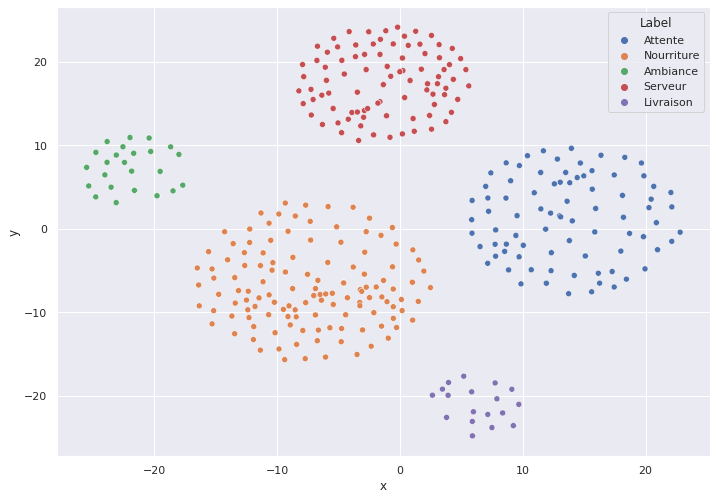

In [35]:
m = TSNE(learning_rate=10, perplexity=20)
tsne_features = m.fit_transform(features)
df_nmf_termine['x'] = tsne_features[:, 0]
df_nmf_termine['y'] = tsne_features[:, 1]

sns.set(rc={'figure.figsize': (11.7, 8.27)})

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', hue='Label', data=df_nmf_termine)

# Conclusion

Nous avons donc 5 Topic que ressortent :
- Topic 1 : **Ambiance** ('restaurant', 'owner', 'review', 'way', 'quality', 'area', 'experience', 'year', 'thing', 'business')
- Topic 2 : **Attente** ('location', 'customer', 'employee', 'manager', 'staff', 'drive', 'order', 'time', 'work', 'attitude')
- Topic 3 : **Nourriture** ('sandwich', 'chicken', 'fry', 'taste', 'cheese', 'meat', 'rice', 'sauce', 'price', 'bread')
- Topic 4 : **Livraison** ('delivery', 'hour', 'driver', 'store', 'time', 'tell', 'phone', 'business', 'day', 'order')
- Topic 5 : **Serveur** ('table', 'server', 'drink', 'people', 'seat', 'bar', 'friend', 'waiter', 'hour', 'waitress')

NMF à l'air de donner des topics bien plus pertinent que LDA, même si les topics sont quasiment similaires.